# Classification


In [1]:
%load_ext lab_black

import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import tensorflow_probability.substrates.jax as tfp
from jax.experimental import optimizers

2022-02-09 07:43:10.610525: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


In [2]:
import gpjax as gpx

key = jr.PRNGKey(123)
tfd = tfp.distributions

## Datasets

We'll simulate a binary dataset where our inputs $x$ are sampled according to $x_i \sim \mathcal{U}(-1., 1.)$ for $1 \leq i \leq 100$. Our corresponding outputs will be calculated according to
$$ y_i = 0.5*\operatorname{sign}(\cos(2*x + \epsilon_i) + 0.5, $$
where $\epsilon_i \sim \mathcal{N}(0, 0.01)$. Note, the multiplication and addition of 0.5 is simply to ensure that our outputs are in $\{0, 1\}$.

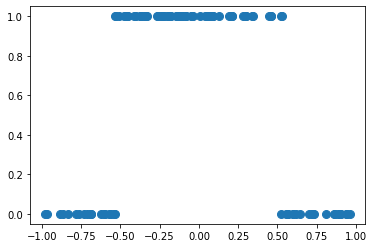

In [3]:
x = jnp.sort(jr.uniform(key, shape=(100, 1), minval=-1.0, maxval=1.0), axis=0)
y = 0.5 * jnp.sign(jnp.cos(3 * x + jr.normal(key, shape=x.shape) * 0.05)) + 0.5
xtest = jnp.linspace(-1.05, 1.05, 500).reshape(-1, 1)
plt.plot(x, y, "o", markersize=8)

In [4]:
training = gpx.Dataset(X=x, y=y)

We can now define our prior Gaussian process such that an RBF kernel has been selected for the purpose of exposition. However, an alternative kernel may be a better choice.

In [5]:
kern = gpx.RBF()
prior = gpx.Prior(kernel=kern)

Now we can proceed to define our likelihood function. In this example, our observations are binary, so we will select a Bernoulli likelihood. Using this likelihood function, we can compute the posterior through the product of our likelihood and prior.

In [6]:
posterior = prior * gpx.Bernoulli(num_datapoints=training.n)
print(type(posterior))

<class 'gpjax.gps.NonConjugatePosterior'>


In [7]:
params, constrainer, unconstrainer = gpx.initialise(posterior)
params = gpx.transform(params, unconstrainer)

With a posterior in place, we can estimate the maximum a posteriori using ObJax's optimisers. However, our Gaussian process is no longer conjugate, meaning that in addition to the kernel's hyperparameters, we are also tasked with learning the values of process' latent function.

In [8]:
mll = jax.jit(posterior.marginal_log_likelihood(training, constrainer, negative=True))

In [10]:
from gpjax.abstractions import fit

opt_init, opt_update, get_params = optimizers.adam(step_size=0.01)
optimised_params = fit(mll, params, opt_init, opt_update, get_params, n_iters=1000)
optimised_params = gpx.transform(optimised_params, constrainer)

100%|██████████| 1000/1000 [00:14<00:00, 70.15it/s, Objective=102.58]            


In [19]:
mu = posterior.mean(training, optimised_params)(xtest)
sigma = jnp.sqrt(jnp.diag(posterior.variance(training, optimised_params)(xtest)))

With the first and centralised second moment computed, we can plot these with the original data overlayed to confirm that our process has done a good job of recovering the latent function.

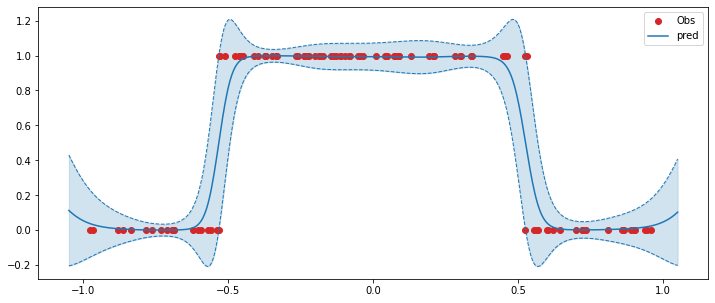

In [20]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(x, y, "o", label="Obs", color="tab:red")
ax.plot(xtest, mu, label="pred", color="tab:blue")
ax.fill_between(
    xtest.squeeze(),
    mu.squeeze() - sigma,
    mu.squeeze() + sigma,
    alpha=0.2,
    color="tab:blue",
)
ax.plot(xtest, mu.squeeze() - sigma, color="tab:blue", linestyle="--", linewidth=1)
ax.plot(xtest, mu.squeeze() + sigma, color="tab:blue", linestyle="--", linewidth=1)

ax.legend()

## System Configuration

In [21]:
%load_ext watermark
%watermark -n -u -v -iv -w -a "Thomas Pinder"

Author: Thomas Pinder

Last updated: Wed Feb 09 2022

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 7.29.0

jax                   : 0.2.21
matplotlib            : 3.4.3
gpjax                 : 0.4.1
tensorflow_probability: 0.15.0
sys                   : 3.9.7 (default, Sep 16 2021, 13:09:58) 
[GCC 7.5.0]

Watermark: 2.2.0

